In [1]:
import random
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, SubsetRandomSampler, random_split
from torchvision.transforms.v2 import Compose, ToImage, Normalize, ToPILImage, RandomHorizontalFlip, Resize, ToDtype

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

# Custom imports
%run -i ../fix_path.py
from data_generation.image_classification import generate_dataset
from stepbystep.v0 import StepByStep

### Data Generation
Our images are quite simple: They have black backgrounds and white lines drawn
on top of them. The lines can be drawn either in a diagonal or in a parallel (to one of
the edges, so they could be either horizontal or vertical) way. So, our classification
problem can be simply stated as: Is the line diagonal?
If the line is diagonal, then we assume it belongs to the positive class. If it is not
diagonal, it belongs to the negative class.

In [2]:
# Data Generation
images, labels = generate_dataset(img_size=5, n_images=300, binary=True, seed=13)

In [3]:
images[0].squeeze()

array([[  0,   0, 255,   0,   0],
       [  0,   0, 255,   0,   0],
       [  0,   0, 255,   0,   0],
       [  0,   0, 255,   0,   0],
       [  0,   0, 255,   0,   0]], dtype=uint8)

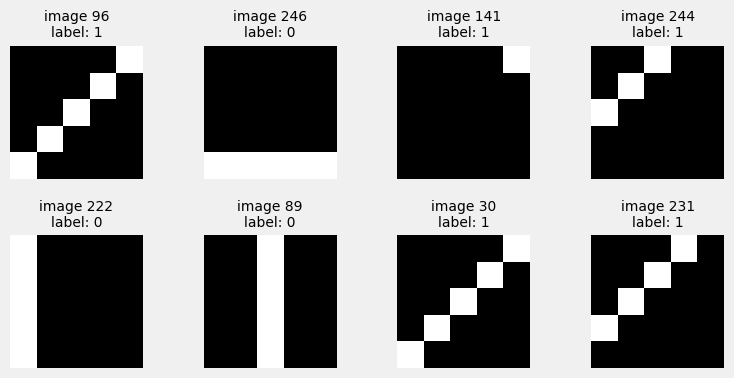

In [4]:
# Pick 8 random indices
np.random.seed(8)
idx = np.random.choice(images.shape[0], 8, replace=False)

# Plot them
fig, axes = plt.subplots(2, 4, figsize=(8, 4))

for i, ax in zip(idx, axes.flatten()):
    ax.imshow(images[i].squeeze(), cmap='gray')  # take channel 0
    ax.axis('off')
    ax.set_title(f'image {i}\nlabel: {labels[i]}', fontsize=10)

plt.tight_layout()
plt.show()

In [5]:
images.shape

(300, 1, 5, 5)

In [6]:
# Pytorch uses CHW - channel, height, weight
example = images[7]
example, example.shape

(array([[[  0, 255,   0,   0,   0],
         [  0,   0, 255,   0,   0],
         [  0,   0,   0, 255,   0],
         [  0,   0,   0,   0, 255],
         [  0,   0,   0,   0,   0]]], dtype=uint8),
 (1, 5, 5))

In [7]:
# NumPy, Matplotlib, PIL and Tensorflow use HWC
# We have to transpose the image to render it in PIL
example_hwc = example.transpose(1, 2, 0)
example_hwc, example_hwc.shape

(array([[[  0],
         [255],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [255],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [255],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [255]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0]]], dtype=uint8),
 (5, 5, 1))

In [8]:
# Convert to PIL image
img = Image.fromarray(example_hwc.squeeze())
img

In [9]:
# ToImage() converts a PIL image, numpy array, tensor to Image (CHW).
#  Image is actually a tensor, it's just a wrapper for images
# NOTE: ToImage() doesn't apply scaling so the pixel values and dtype are left unchanged
image_tensor = ToImage()(example_hwc)
image_tensor, image_tensor.shape, image_tensor.dtype, type(image_tensor), isinstance(image_tensor, torch.Tensor)

(Image([[[  0, 255,   0,   0,   0],
         [  0,   0, 255,   0,   0],
         [  0,   0,   0, 255,   0],
         [  0,   0,   0,   0, 255],
         [  0,   0,   0,   0,   0]]], dtype=torch.uint8, ),
 torch.Size([1, 5, 5]),
 torch.uint8,
 torchvision.tv_tensors._image.Image,
 True)

In [10]:
# ToDtype Converts the Image to a torch.Tensor, scales it if scale=True
image_scaled = ToDtype(torch.float32, scale=True) (image_tensor)
image_scaled

Image([[[0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.]]], )

<PIL.Image.Image image mode=L size=5x5 at 0x7246F8B12600> <class 'PIL.Image.Image'>


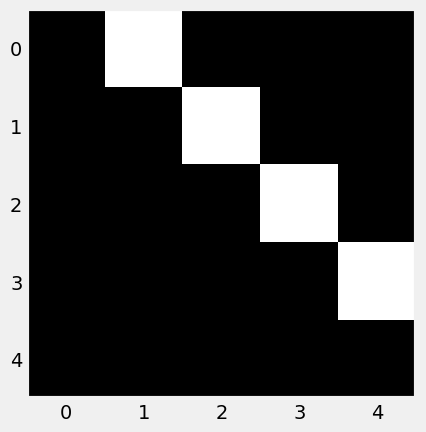

In [11]:
# Converting a Tensor to PILImage
# ToPILImage() can take either a tensor in PyTorch shape (CHW) or a Numpy array in PIL shape (HWC) as inputs.
image_pil = ToPILImage()(image_tensor)
print(image_pil, type(image_pil))
plt.imshow(image_pil, cmap="gray")
plt.grid(False)
plt.show()

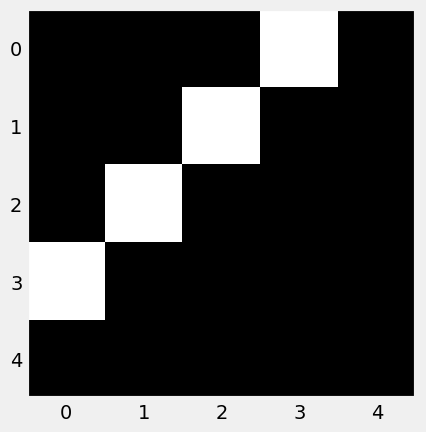

In [12]:
# Other data augmentation techniques: 
# Resize(), CenterCrop(), GrayScale(),
# RandomHorizontalFlip(), and RandomRotation(), to name a few.
image_flipped = RandomHorizontalFlip(p=1)(image_pil)
plt.imshow(image_flipped, cmap="gray")
plt.grid(False)
plt.show()

In [13]:
image_scaled

Image([[[0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.]]], )

In [14]:
# Standardization (like MinMaxScaler) using mean and std of 0.5
image_normalized = Normalize(mean=[0.5], std=[0.5])(image_scaled)
image_normalized

Image([[[-1.,  1., -1., -1., -1.],
        [-1., -1.,  1., -1., -1.],
        [-1., -1., -1.,  1., -1.],
        [-1., -1., -1., -1.,  1.],
        [-1., -1., -1., -1., -1.]]], )

In [15]:
type(image_pil)

PIL.Image.Image

In [16]:
# Using Compose
transforms = Compose([
    ToImage(),
    RandomHorizontalFlip(p=1.0),
    ToDtype(torch.float32, scale=True),
    Normalize(mean=[0.5], std=[0.5])
])

img_out = transforms(image_pil)
img_out

Image([[[-1., -1., -1.,  1., -1.],
        [-1., -1.,  1., -1., -1.],
        [-1.,  1., -1., -1., -1.],
        [ 1., -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1.]]], )

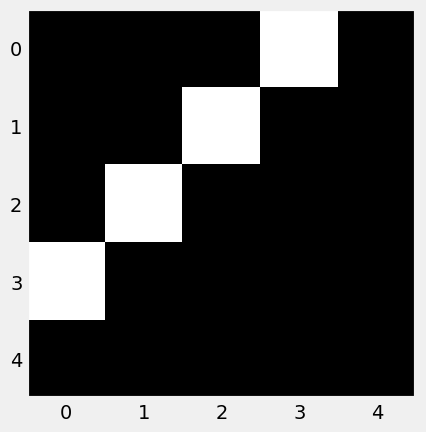

In [17]:
plt.imshow(img_out.numpy().squeeze(), cmap="gray")
plt.grid(False)
plt.show()

## Transformed Dataset

In [18]:
class TransformedTensorDataset(Dataset):
    def __init__(self, features: torch.types.Tensor, labels: torch.types.Tensor, transform=None):
        self.features = features
        self.labels = labels
        self.transform = transform
    def __getitem__(self, index):
        x = self.features[index]
        y = self.labels[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.features)

In [19]:
images.shape, type(images), labels.shape, type(labels)

((300, 1, 5, 5), numpy.ndarray, (300,), numpy.ndarray)

In [20]:
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()
x_tensor.shape, type(x_tensor), y_tensor.shape, type(y_tensor)

(torch.Size([300, 1, 5, 5]), torch.Tensor, torch.Size([300, 1]), torch.Tensor)

In [21]:
# Define the sequence of transformations
train_composer = Compose([
    RandomHorizontalFlip(p=0.5),
    Normalize(mean=[0.5], std=[0.5])
])

val_composer = Compose([
    Normalize(mean=[0.5], std=[0.5])
])

In [22]:
# Create the train and val datasets
indices = torch.randperm(len(x_tensor))
train_size = int(0.8 * len(x_tensor))
len(indices), indices[:4], train_size

(300, tensor([178, 291,  72, 266]), 240)

In [23]:
train_indices = indices[:train_size]
val_indices = indices[train_size:]

In [24]:
train_dataset = TransformedTensorDataset(
    x_tensor[train_indices], 
    y_tensor[train_indices], 
    transform=train_composer
)

val_dataset = TransformedTensorDataset(x_tensor[val_indices], y_tensor[val_indices], transform=val_composer)

#### Handling Class Imbalance

In [25]:
train_labels = train_dataset.labels
train_labels.size(), train_labels[:4]

(torch.Size([240, 1]),
 tensor([[1.],
         [0.],
         [0.],
         [0.]]))

In [26]:
# Compute class weights (inverse frequency)
classes, counts = train_labels.unique(return_counts=True)
class_weights = 1.0 / counts.float()
print(classes, counts)
print(class_weights)

tensor([0., 1.]) tensor([ 84, 156])
tensor([0.0119, 0.0064])


In [27]:
# Assign a weight to each sample
# .long() converts the labels to int64 (required for indexing)
# .squeeze() removes the extra dimension
sample_weights = class_weights[train_labels.long().squeeze()]
sample_weights[:4], train_labels[:4]

(tensor([0.0064, 0.0119, 0.0119, 0.0119]),
 tensor([[1.],
         [0.],
         [0.],
         [0.]]))

In [28]:
# Create the sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Redefine the train loader using the sampler
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    sampler=sampler
)

# Validation loader remains unchanged
val_loader = DataLoader(val_dataset, batch_size=16)

## Simple Logistic Regression Model with BCELoss

In [29]:
batch_images, batch_labels = next(iter(train_loader))
batch_images.shape, batch_labels.shape

(torch.Size([16, 1, 5, 5]), torch.Size([16, 1]))

In [30]:
lr = 0.001
model_logistic = nn.Sequential(
    nn.Flatten(),
    nn.Linear(25, 1, bias=False),
    nn.Sigmoid(),
)

optimizer_logistic = optim.SGD(params=model_logistic.parameters(), lr=lr)
binary_loss_fn = nn.BCELoss()

In [31]:
n_epochs = 100
sbs_logistic = StepByStep(model_logistic,binary_loss_fn, optimizer_logistic)
sbs_logistic.set_loaders(train_loader, val_loader)
sbs_logistic.train(n_epochs)

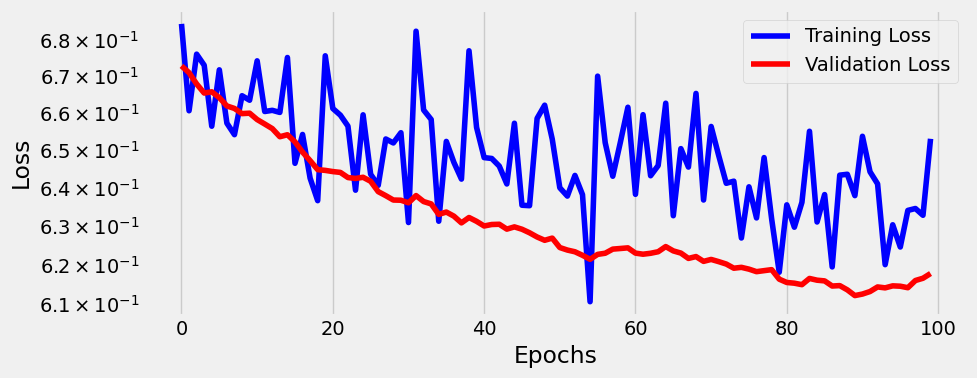

In [32]:
fig = sbs_logistic.plot_losses()

## Activation Functions
- Sigmoid
- TanH
- ReLU
- Leaky ReLU
- Parametric ReLU
- Softmax

In [43]:
dummy_z = torch.arange(-2, 3).float()
dummy_z 

tensor([-2., -1.,  0.,  1.,  2.])

### Sigmoid
$\sigma(x) = \frac{1}{1 + e^{-z}}$
- Squashes input into the range (0, 1). 
- Used for binary classification where the output is the probability of a single class being positive
- Suffers from vanishing gradients — when inputs are very positive or very negative, the gradient becomes extremely small, slowing or stopping learning.

In [44]:
torch.sigmoid(dummy_z)

tensor([0.1192, 0.2689, 0.5000, 0.7311, 0.8808])

### TanH
$\tanh(z) = \frac{e^{z} - e^{-z}}{e^{z} + e^{-z}}$
- Outputs between (−1, 1); zero-centered.
- Also suffers from vanishing gradients for large |z|; neurons saturate at −1 or 1.

In [45]:
torch.tanh(dummy_z)

tensor([-0.9640, -0.7616,  0.0000,  0.7616,  0.9640])

### ReLU
$\text{ReLU}(z) = \max(0, z)$
- Aims to solve the problem (vanishing gradient) with it's predecesors (Sigmoid and TanH)
- Very simple; outputs 0 for negative values and x for positive.
- Can create dead neurons—if a neuron outputs 0 repeatedly, its gradient becomes 0 and it may never recover.

In [46]:
F.relu(dummy_z)

tensor([0., 0., 0., 1., 2.])

### Leaky ReLU
$\text{Leaky ReLU}(z) = 
\begin{cases}
z, & z \ge 0 \\
\alpha z, & z < 0
\end{cases}
$
- Aims to solve the problem (dead neurons) with ReLU. 
- It introduces a small activation value (coefficient of leakage), default 0.01, that makes sure we don't get 0 for negative inputs
- Outputs z, if z is positive, otherwise $\alpha \times z$, where $\alpha$ = 0.01

In [48]:
F.leaky_relu(dummy_z, negative_slope=0.01)

tensor([-0.0200, -0.0100,  0.0000,  1.0000,  2.0000])

### Parametric ReLU (PReLU)
$\text{PReLU}(z) = 
\begin{cases}
z, & z \ge 0 \\
a z, & z < 0
\end{cases}
$

- Generalizes Leaky ReLU by learning the coefficient of leakage $\alpha$.
- Instead of hardcoding $\alpha$, we can set it as a learning parameter, with a default value, say 0.25, such that the model automatically learns the optimal value that would actually prevent the dead neurons.
- Adds extra parameters; risk of overfitting if poorly regularized.

In [49]:
F.prelu(dummy_z, weight=torch.tensor(0.25))

tensor([-0.5000, -0.2500,  0.0000,  1.0000,  2.0000])

### Softmax
$\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j} e^{z_j}}$
- Converts logits into a probability distribution (outputs sum to 1).
- Used for multiclass classification where each output represents the probability of being in a given class
- Can suffer from vanishing gradients when one class probability becomes extremely dominant; also sensitive to large input scale.

In [57]:
torch.softmax(dummy_z, dim=0)

tensor([0.0117, 0.0317, 0.0861, 0.2341, 0.6364])